# Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from scipy import stats
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')


# Healthy Patients

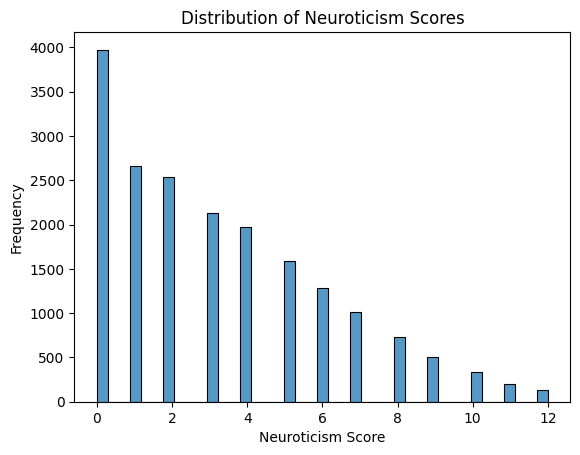

In [2]:
input_path = '/Users/baileyng/MIND_data/ukb_NEO/NEO_tabular_all_healthy.csv'
df = pd.read_csv(input_path, index_col=0)

# Histogram
sns.histplot(df['20127-0.0'])
plt.title('Distribution of Neuroticism Scores')
plt.xlabel('Neuroticism Score')
plt.ylabel('Frequency')
plt.show()

In [3]:
# load FC regions
with open('/Users/baileyng/MIND_models/FC_colnames.txt', 'r') as f:
    fc_regions = [line.strip() for line in f.readlines()]

rename = pd.read_csv('/Users/baileyng/MIND_models/region_names/col_renames.csv')
rename_dict = dict(zip(rename['datafield_code'], rename['datafield_name']))

# rename columns
df = df.rename(columns=rename_dict)

In [4]:
# Process categorical variables
df['sex_encoded'] = LabelEncoder().fit_transform(df['sex'])

centre_dummies = pd.get_dummies(df['assessment_centre'], prefix='centre', drop_first=True)
df = pd.concat([df, centre_dummies], axis=1)

#Get centre dummy column names
centre_cols = [col for col in df.columns if col.startswith('centre_')]

In [5]:
# Prepare base features
df['age_squared'] = df['age'] ** 2
df['age_sex_interaction'] = df['age'] * df['sex_encoded']

In [6]:
# Initialize storage for results
results = []

# Fit linear model for each FC region
for region in fc_regions:
    try:
        feature_cols = ['age', 'sex_encoded', 'age_sex_interaction', 'age_squared',
                        region, 'head_motion'] + centre_cols
        
        # Drop rows with missing values
        model_df = df[feature_cols + ['neuroticism_score']].dropna()

        X = model_df[feature_cols]
        y = model_df['neuroticism_score']

        # Fit linear regression model
        model = LinearRegression()
        model.fit(X, y)

        # Calculate R-squared
        y_pred = model.predict(X)
        r_squared = model.score(X, y)

        # Calculate adjusted R-squared
        n = len(y)
        p = X.shape[1]
        adj_r_squared = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

        # Calculate residual standard error
        residuals = y - y_pred
        mse = np.mean(residuals ** 2)
        rmse = np.sqrt(mse)

        # Store results
        result = {
            'region_pair': region,
            'n_samples': n,
            'r_squared': r_squared,
            'rmse': rmse,
            'intercept': model.intercept_
        }

        # Add coefficients
        for i, col in enumerate(feature_cols):
            result[f'coef_{col}'] = model.coef_[i]

        results.append(result)
    
    except Exception as e:
        print(f"Error fitting model for {region}: {e}")
    
# Convert results to DataFrame
results_df = pd.DataFrame(results)
print(f"Successfully fitted models for {len(results_df)} regions")
print(f"Results shape: {results_df.shape}")


Successfully fitted models for 210 regions
Results shape: (210, 222)
